## 1. Preparing our dataset
<p><em>These recommendations are so on point! How does this playlist know me so well?</em></p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="600px"></p>
<p>Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.</p>
<p>For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.</p>
<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.</p>
<p>Let's start by creating two pandas <code>DataFrames</code> out of these files that we can merge so we have features and labels (often also referred to as <code>X</code> and <code>y</code>) for the classification later on.</p>

In [749]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json',precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[["track_id", "genre_top"]], on="track_id")

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
track_id            4802 non-null int64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


## 2. Pairwise relationships between continuous variables
<p>We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:</p>
<ul>
<li>To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).</li>
<li>When our datasets are very large, using fewer features can drastically speed up our computation time.</li>
</ul>
<p>To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the <code>pandas</code> package.</p>

In [751]:
# Create a correlation matrix
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,track_id,valence
acousticness,1,-0.189599,-0.477273,0.110033,0.0413193,0.0387845,-0.110701,-0.279829,-0.0854362
danceability,-0.189599,1,0.0453446,-0.118033,-0.143339,0.171311,-0.0943519,0.102056,0.428515
energy,-0.477273,0.0453446,1,-0.00241179,0.0457524,-0.00864488,0.227324,0.121991,0.219384
instrumentalness,0.110033,-0.118033,-0.00241179,1,-0.0585932,-0.216689,0.0230032,-0.283206,-0.1452
liveness,0.0413193,-0.143339,0.0457524,-0.0585932,1,0.0731041,-0.00756641,-0.00405934,-0.0178859
speechiness,0.0387845,0.171311,-0.00864488,-0.216689,0.0731041,1,0.0321876,-0.0750767,0.0947941
tempo,-0.110701,-0.0943519,0.227324,0.0230032,-0.00756641,0.0321876,1,0.004313,0.129911
track_id,-0.279829,0.102056,0.121991,-0.283206,-0.00405934,-0.0750767,0.004313,1,0.0202007
valence,-0.0854362,0.428515,0.219384,-0.1452,-0.0178859,0.0947941,0.129911,0.0202007,1


## 3. Normalizing the feature data
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called <strong>principal component analysis (PCA)</strong>. </p>
<p>It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes. </p>
<p>However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through <em>standardization</em>, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).</p>

In [753]:
# Define our features 
features = echo_tracks.drop(["genre_top", "track_id"],axis=1)

# Define our labels
labels = echo_tracks["genre_top"]

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler
print(type(features))
# Scale the features and set the values to a new variable
scaler = StandardScaler()

scaled_train_features = scaler.fit_transform(features)

<class 'pandas.core.frame.DataFrame'>


## 4. Principal Component Analysis on our scaled data
<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use <strong>scree-plots</strong> and <strong>cumulative explained ratio plots</strong> to find the number of components to use in further analyses.</p>
<p>Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.</p>

Text(0.5,0,'Principal Component #')

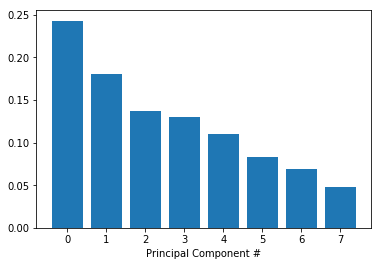

In [755]:
# Just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

## 5. Further visualization of PCA
<p>Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method. </p>
<p>But all is not lost! Instead, we can also look at the <strong>cumulative explained variance plot</strong> to determine how many features are required to explain, say, about 90% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.</p>

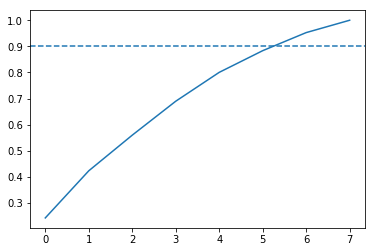

In [757]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## 6. Train a decision tree to classify genre
<p>Now we can use the lower dimensional PCA projection of the data to classify songs into genres. To do that, we first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.</p>
<p>Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.</p>
<p>Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></p>

In [759]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels,random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)


## 7. Compare our decision tree to a logistic regression
<p>Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.</p>
<p>Sometimes simplest is best, and so we will start by applying <strong>logistic regression</strong>. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified). </p>

In [761]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.66      0.66      0.66       229
       Rock       0.92      0.92      0.92       972

avg / total       0.87      0.87      0.87      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.75      0.57      0.65       229
       Rock       0.90      0.95      0.93       972

avg / total       0.87      0.88      0.87      1201



## 8. Balance our data for greater performance
<p>Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. </p>
<p>Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.</p>
<p>To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in <em>sample size</em> of our data points when weighting our classes here, and not relative importance of each class. </p>

In [763]:
# Subset only the hip-hop tracks, and then only the rock tracks

hop_only = echo_tracks.loc[(echo_tracks.genre_top =='Hip-Hop')]
rock_only = echo_tracks.loc[(echo_tracks.genre_top =='Rock')]


# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only,hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels, random_state=10)

## 9. Does balancing our dataset improve model bias?
<p>We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance. </p>
<p>Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.</p>

In [765]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.77      0.77      0.77       230
       Rock       0.76      0.76      0.76       225

avg / total       0.76      0.76      0.76       455

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.82      0.83      0.82       230
       Rock       0.82      0.81      0.82       225

avg / total       0.82      0.82      0.82       455



## 10. Using cross-validation to evaluate our models
<p>Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called <strong>cross-validation</strong> (CV). This step allows us to compare models in a more rigorous fashion.</p>
<p>Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as <strong>K-fold</strong> CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.</p>

In [767]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree,pca_projection, labels,cv=kf)
logit_score = cross_val_score()

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree), "Logistic Regression:", np.mean(logit_score))

TypeError: estimator should be an estimator implementing 'fit' method,       acousticness  danceability    energy  instrumentalness  liveness  \
792       0.007713      0.493602  0.608453      4.000000e-10  0.105370   
2063      0.958873      0.274609  0.989482      9.193623e-01  0.546516   
2793      0.981435      0.058431  0.892774      9.608991e-01  0.201342   
1947      0.637573      0.282463  0.953610      8.423930e-01  0.112779   
2592      0.002964      0.461667  0.596180      8.971766e-01  0.382457   
1367      0.824546      0.560141  0.162270      3.688300e-06  0.164875   
1956      0.007610      0.690719  0.663286      8.588944e-01  0.084784   
81        0.944660      0.725553  0.364310      8.249918e-01  0.110965   
3958      0.706391      0.436263  0.771972      7.727994e-01  0.110742   
1738      0.304973      0.077607  0.985286      6.842741e-01  0.311175   
3182      0.937060      0.293422  0.673977      7.760355e-01  0.092138   
1257      0.932161      0.353420  0.424964      6.613206e-01  0.130184   
3815      0.339155      0.556486  0.783264      6.906401e-01  0.092997   
3041      0.176505      0.161526  0.182891      8.255170e-01  0.167182   
366       0.891594      0.064581  0.160183      9.657885e-01  0.191192   
1195      0.000175      0.150482  0.826862      5.530178e-01  0.126207   
3644      0.920278      0.381401  0.452833      9.579746e-01  0.283875   
4503      0.176009      0.172210  0.965000      8.896415e-01  0.366177   
1301      0.378380      0.294272  0.802531      7.294290e-01  0.124726   
4632      0.002018      0.406713  0.771775      7.890275e-01  0.370834   
4767      0.278760      0.530780  0.674965      9.146735e-01  0.278280   
3486      0.016076      0.165609  0.875123      6.690930e-01  0.143639   
4612      0.596509      0.421085  0.683463      9.475822e-01  0.114409   
1752      0.000573      0.280603  0.952339      8.678530e-05  0.372968   
1177      0.527236      0.660151  0.421442      9.742763e-02  0.107759   
1362      0.716129      0.514894  0.342051      4.423290e-02  0.211526   
2595      0.523209      0.377219  0.031624      9.619072e-01  0.111190   
1767      0.883935      0.155819  0.037121      9.255618e-01  0.318604   
1553      0.989515      0.285662  0.345082      9.286016e-01  0.104757   
3321      0.000039      0.397672  0.696177      9.068462e-01  0.158992   
...            ...           ...       ...               ...       ...   
4657      0.964425      0.656303  0.625105      9.594968e-01  0.135086   
4658      0.292998      0.819943  0.711956      7.263862e-01  0.109753   
4659      0.889550      0.624561  0.659617      9.117093e-01  0.093092   
4660      0.024395      0.771742  0.524190      8.691706e-01  0.094248   
4661      0.013170      0.816246  0.622010      9.079598e-01  0.185173   
4662      0.589622      0.169444  0.685519      9.505743e-01  0.405340   
4663      0.097117      0.600965  0.691345      8.079722e-01  0.121511   
4683      0.159646      0.572437  0.828661      9.229263e-01  0.101578   
4684      0.454430      0.606930  0.466847      9.204248e-01  0.243719   
4685      0.942466      0.540065  0.528884      8.000000e-09  0.143760   
4686      0.826636      0.625281  0.354174      1.218390e-03  0.247668   
4687      0.298080      0.190255  0.053538      8.985668e-01  0.114393   
4688      0.027748      0.136749  0.695610      4.099882e-02  0.070570   
4689      0.645819      0.444522  0.569576      5.654632e-01  0.083793   
4690      0.734563      0.480515  0.586120      9.780100e-06  0.110861   
4692      0.959232      0.467568  0.474276      7.245712e-01  0.111588   
4693      0.754852      0.525563  0.575679      7.809800e-06  0.168556   
4694      0.182938      0.672995  0.609045      3.212828e-01  0.312801   
4695      0.773108      0.777655  0.494050      4.633735e-03  0.133607   
4696      0.672224      0.397043  0.471473      4.731359e-01  0.310509   
4697      0.547040      0.616115  0.433063      1.095302e-02  0.167519   
4698      0.554841      0.346705  0.458727      5.467915e-01  0.075319   
4699      0.561911      0.367000  0.683790      1.393414e-01  0.152860   
4700      0.112321      0.441252  0.467405      3.369176e-01  0.333063   
4701      0.694399      0.536156  0.525294      1.248707e-02  0.389621   
4703      0.485198      0.499766  0.639737      5.634911e-02  0.122473   
4704      0.175653      0.629245  0.638676      3.346280e-05  0.078074   
4705      0.347418      0.798553  0.379532      6.951535e-02  0.089495   
4706      0.765406      0.714296  0.188425      2.748600e-06  0.118314   
4707      0.712548      0.612108  0.196388      1.662000e-07  0.314337   

      speechiness    tempo   valence  
792      0.024686   72.059  0.710390  
2063     0.185316   84.173  0.033208  
2793     0.140291  200.793  0.037663  
1947     0.083414  127.452  0.086022  
2592     0.039156  142.122  0.297013  
1367     0.675227  151.634  0.378251  
1956     0.035185  125.237  0.902316  
81       0.040400  107.935  0.965362  
3958     0.032844  116.330  0.629809  
1738     0.067269  178.194  0.262651  
3182     0.033379  109.009  0.522670  
1257     0.052278  146.780  0.467706  
3815     0.034013  132.894  0.704084  
3041     0.040527  139.961  0.036737  
366      0.051416  183.713  0.224423  
1195     0.045497  176.952  0.383175  
3644     0.040415   69.117  0.076719  
4503     0.083880  141.805  0.121373  
1301     0.043088  131.162  0.352658  
4632     0.034049  107.640  0.698925  
4767     0.026542   98.403  0.849615  
3486     0.080147  158.097  0.076617  
4612     0.045262  179.996  0.687209  
1752     0.098794  151.043  0.198531  
1177     0.078622  180.369  0.334327  
1362     0.590704  143.480  0.284495  
2595     0.070357  106.693  0.035111  
1767     0.045532  112.508  0.036213  
1553     0.031283   93.621  0.537212  
3321     0.036606  130.451  0.730697  
...           ...      ...       ...  
4657     0.023409   93.924  0.917434  
4658     0.063216   91.937  0.963299  
4659     0.031556   90.986  0.886141  
4660     0.192837   95.194  0.979805  
4661     0.068744   90.994  0.478143  
4662     0.058257   69.943  0.174956  
4663     0.039809  175.794  0.847218  
4683     0.084620   91.803  0.749511  
4684     0.109783   90.120  0.610855  
4685     0.952314  176.141  0.403830  
4686     0.955339  103.737  0.681293  
4687     0.028558  134.170  0.092404  
4688     0.263873  224.955  0.485370  
4689     0.486712  105.222  0.402795  
4690     0.442362   88.095  0.551643  
4692     0.337635  170.352  0.435967  
4693     0.492237  187.809  0.824220  
4694     0.103120   87.017  0.480242  
4695     0.305560   86.927  0.499966  
4696     0.268783   90.931  0.676623  
4697     0.470203  183.873  0.818161  
4698     0.110970   89.522  0.602306  
4699     0.184646   81.649  0.877813  
4700     0.185678  151.902  0.508228  
4701     0.589674  116.190  0.766879  
4703     0.232684   86.858  0.345106  
4704     0.400079  183.984  0.690531  
4705     0.164298   90.016  0.919182  
4706     0.958019  179.838  0.447817  
4707     0.955960   87.826  0.658864  

[1820 rows x 8 columns] was passed